In [1]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda
# from torch.nn.utils import spectral_norm
from torch.nn.utils.parametrizations import spectral_norm
from torchmetrics.image.fid import FrechetInceptionDistance
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

C:\Users\User\anaconda3\envs\FYDP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.1.0
torchvision version: 0.16.0+cpu


In [2]:
# import sys

# print("Python Version:", sys.version)

In [3]:
# !pip install --upgrade certifi

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [5]:

# def scaleTransform(x):return (x*2) -  1

# def scaleTransform(x):

filecontent = """
def scaleTransform(x):
    return (x*2) -  1
"""
with open('utils.py' , 'w') as f:
    f.write(filecontent)
from utils import scaleTransform


train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.Compose([ToTensor(), Lambda(scaleTransform)]), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data


test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=torchvision.transforms.Compose([ToTensor(),Lambda(scaleTransform) ]) 
)

from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 128

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True , # shuffle data every epoch? , 
    num_workers=6, pin_memory=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,num_workers=6,pin_memory=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Files already downloaded and verified
Files already downloaded and verified
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001AE72BB29D0>, <torch.utils.data.dataloader.DataLoader object at 0x000001AE72BB2940>)
Length of train dataloader: 391 batches of 128
Length of test dataloader: 79 batches of 128



### Conditional BatchNorm 
https://arxiv.org/pdf/1707.00683v3.pdf
- Normal Batchnorm are used to stablise gan training , thus making convergence faster
- Just like simple concatenation and using embedding layers at the start, 
- For Conditional BatchNorm, each class has its own weight and bias, and each class has its own value of beta and gamma


### Spectral Normalisation 
https://arxiv.org/pdf/1802.05957v1.pdf
- it is a weight normalisation technique that prevents vanishing/ exploding gradients, by rescaling the weight tensor with spectral norm σσ of the weight matrix
- It is an alternative to to using gradient penalty to enforce the 1-Lipschitz Continuity, thus another method to stablising the training
- It is computationally cheaper than gradient penalty, thus allowing better performance in shorter amount of training time
- Loss function : the Spectral Normalisation paper achieved best results with hinge loss, so I tried the hinge loss

### Hinge Loss 
https://arxiv.org/pdf/1705.02894.pdf
-  Based on support vector machines classifier
- The discriminator learns a boundry between real and fake samples, that the real and generated images are the furthest apart 
- The generator will generate images closer to the boundry found by the discrminator
- It is shown in paper that it increases stability and alliviates mode collaspe
- The "theoretical results" in the paper also shown that  Nash equilibrium between discriminator and generator is achieved (when none of the networks can make the other improve further)


### Improvement from previous:
- RLC regularisation
 Regularizing Generative Adversarial Networks under Limited Data https://arxiv.org/pdf/2104.03310.pdf
 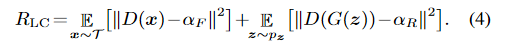

-Cifar 10 is a smaller dataset, which means the discriminator more prone to overfitting,
-  RLC regularisation term is added to the discriminator loss to regularise the discriminator, regularising the discriminator
- This is appropriate this regularisation method is to regularising the discrminator when there is limited data


In [6]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        
        try:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        except:
            pass


class BatchNorm2d(torch.nn.BatchNorm2d):
    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()


class CategoricalConditionalBatchNorm(torch.nn.Module):
    #implementation from https://github.com/t-vi/pytorch-tvmisc/blob/master/wasserstein-distance/sn_projection_cgan_64x64_143c.ipynb
    # as in the chainer SN-GAN implementation, we keep per-cat weight and bias
    def __init__(self, num_features, num_cats, eps=2e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()

    def forward(self, input, cats):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        out = torch.nn.functional.batch_norm(
            input, self.running_mean, self.running_var, None, None,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)
        if self.affine:
            shape = [input.size(0), self.num_features] + (input.dim() - 2) * [1]
            weight = self.weight.index_select(0, cats).view(shape)
            bias = self.bias.index_select(0, cats).view(shape)
            out = out * weight + bias
        return out

    def extra_repr(self):
        return '{num_features}, num_cats={num_cats}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children


#Architecture of discriminator and generator modified from https://github.com/dterjek/adversarial_lipschitz_regularization/blob/master/wgan_alp.py
class Resnet_Block(nn.Module):
    def __init__(self,filters,bn = True):
        super().__init__() 
        layers = []
        for _ in range(2):
            if bn:
                layers.append(nn.CategoricalConditionalBatchNorm(filters , 10) )
            layers.append(nn.ReLU())
            layers.append( (nn.LazyConv2d(filters, 3, padding ='same')))
            self.sequentialbranch = nn.Sequential(*layers)

    def forward(self, x):
        return self.sequentialbranch(x) + x 

class Resnet_Block_down(nn.Module):
    def __init__(self,filters,bn = True):
        super().__init__() 

        layers = []
        if bn:
            layers.append(CategoricalConditionalBatchNorm(filters , 10) )
        layers.append(nn.ReLU())
        layers.append( (nn.LazyConv2d(filters, 3, padding ='same')))
        if bn:
            layers.append(CategoricalConditionalBatchNorm(filters , 10) )
        layers.append(nn.ReLU())
        layers.append( (nn.LazyConv2d(filters, 3, padding ='same')))
        layers.append(nn.AvgPool2d(2 , 2))
        self.mainbranch = nn.Sequential(*layers)
        self.sidebranch = nn.Sequential( (nn.LazyConv2d(filters, 3, padding ='same')) , 
                                         nn.AvgPool2d(2 , 2))
        

    def forward(self, x):
        return self.mainbranch(x) + self.sidebranch(x) 
        

class Resnet_Block_up(nn.Module):
    def __init__(self,filters,bn = True):
        super().__init__() 

       
        
        self.bn1 =    CategoricalConditionalBatchNorm(filters , 10) 
        layers = []
        layers.append(nn.ReLU())
        layers.append( nn.Upsample(scale_factor=2))
        layers.append( (nn.LazyConv2d(filters, 3, padding ='same')))
        self.mainbranch1 = nn.Sequential(*layers)
        self.bn2 =CategoricalConditionalBatchNorm(filters , 10)
        layers = []
        layers.append(nn.ReLU())
        layers.append( (nn.LazyConv2d(filters, 3, padding ='same')))
        self.mainbranch2 =  nn.Sequential(*layers)

        # self.mainbranch = nn.Sequential(*layers)
        self.sidebranch = nn.Sequential( nn.Upsample(scale_factor=2)  ,  nn.LazyConv2d(filters, 1, padding ='same') )

    def forward(self, x, y):
        skip = x
        x= self.bn1(x, y)
        x = self.mainbranch1(x)
        x= self.bn2(x,y)
        x = self.mainbranch2(x)

        return x  + self.sidebranch(skip) 
        

class Resnet_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.class_processing = nn.Sequential(nn.Embedding(10 , 50 ), nn.LazyLinear( 32*32))
 

        self.initial_block_main = nn.Sequential(
            nn.LazyConv2d( 128, 3, padding ='same') , 
            nn.ReLU() , 
            (nn.LazyConv2d(128, 3, padding ='same')) ,
            nn.AvgPool2d(2 , 2), 
        )

        self.initial_block_side = nn.Sequential(
            nn.AvgPool2d(2 , 2),
            ( nn.LazyConv2d( 128, 3, padding ='same'))
        )

        self.main_blocks = nn.Sequential(
            Resnet_Block_down( 128 , False),
            Resnet_Block(128, False),
            Resnet_Block(128, False)

        )


        self.final = nn.Sequential( 
            nn.ReLU(), 
            nn.AdaptiveMaxPool2d(output_size=1), 
            nn.Flatten() , 
            
        )
        self.class_embed = spectral_norm(nn.Embedding(10, 128))


        self.finallinear = nn.LazyLinear( 1  )

        
        _ = self(torch.randn(128,3,32,32) , torch.randint(high = 10, size = (128,)))

        self.apply(init_weights)

        for child in get_children(self):
            if  isinstance(child , nn.LazyConv2d ) or isinstance(child , nn.Conv2d ) or isinstance( child,( nn.Linear , nn.LazyLinear)):
                child = spectral_norm(child)


        

    def forward(self, x , y):
        y= torch.reshape(self.class_processing( y), [-1, 1,32,32])  
        concated= torch.cat(  (x,y) , dim = 1 ) 
        x = self.initial_block_main(x) + self.initial_block_side(x)
        x = self.main_blocks(x)
        x= self.final(x)
        out = self.finallinear(x)

        # x += torch.sum(self.class_embed(y) * x, dim=1, keepdim=True)
        
        #adding label information to discriminator via projection
        #https://github.com/crcrpar/pytorch.sngan_projection/blob/master/models/discriminators/snresnet.py
        #https://arxiv.org/pdf/1802.05637v2.pdf

        return out #+ torch.sum(self.class_embed(y) * x, dim=1, keepdim=True)


class Resnet_Generator(nn.Module):
    def __init__(self):
        super().__init__() 

        self.initial_linear = nn.Linear( 128, 4*4*128)
        # self.class_processing = nn.Sequential(nn.Embedding(10 , 50 ), nn.LazyLinear(4*4))


        self.main_blocks = nn.ModuleList(
            [Resnet_Block_up( 128 , True),
            Resnet_Block_up(128, True),
            Resnet_Block_up(128, True)]
        )

        self.final = nn.Sequential( 
            nn.LazyBatchNorm2d() , 
            nn.ReLU(),
            nn.LazyConv2d( 3, 3, padding ='same'),
            nn.Tanh()
        )
        
        _ = self(torch.randn(128,128) , torch.randint(high = 10, size = (128,)))
        self.apply(init_weights)



        for child in get_children(self):
            if  isinstance(child , (nn.LazyConv2d , nn.Conv2d, nn.LazyLinear) )  :
                child = spectral_norm(child)

    def forward(self, x,y):
        x = self.initial_linear(x) 
        x = torch.reshape( x , [-1, 128, 4,4])
        # y = torch.reshape( self.class_processing(y), [-1,1, 4,4 ] )
        # concat = torch.cat( ( x,y) ,dim =1 )
        # x = self.main_blocks(x)
        for block in self.main_blocks:
            x = block(x,y)

        x = self.final(x)

        if not self.training:
            # to generate images to calculate kid/fid
            x = 255 * (x.clamp(-1, 1) * 0.5 + 0.5)
            x = x.to(torch.uint8)
        return x



# test_dis= Resnet_Discriminator()
# test_gen = Resnet_Generator() 
# # with torch.no_grad():
#     outputs = test_gen(torch.randn( 128 , 128 ))
# import numpy as np 
# model_parameters = filter(lambda p: p.requires_grad, test_gen.parameters())
# params = sum([np.prod(p.size()) for p in  test_gen.parameters()])

In [7]:
# pip install wandb


In [8]:
from pytorch_lightning.core import LightningModule
from pytorch_lightning.trainer import Trainer
import torch_fidelity
import numpy as np 
import wandb
import collections 
torch.manual_seed(1)

def hinge_loss(dpred_real,dpred_fake ):
    # https://arxiv.org/abs/1705.02894v2
    return (-torch.minimum(torch.tensor(0.0, dtype=torch.float, device=dpred_real.device),dpred_real - 1.0,).mean()
        - 
        torch.minimum(torch.tensor(0.0, dtype=torch.float, device=dpred_fake.device),-dpred_fake - 1.0,).mean())
    
import shutil, os


def rlc_reg( dpred_real,dpred_fake) -> torch.Tensor:
    regularization_loss = (dpred_real -1.0).norm(dim=-1).pow(2).mean()  + (dpred_fake -1.0).norm(dim=-1).pow(2).mean()
    return 0.15* regularization_loss

def r1_reg( dpred_real,dpred_fake) -> torch.Tensor:
    regularization_loss = (dpred_real -1.0).norm(dim=-1).pow(2).mean()  + (dpred_fake -1.0).norm(dim=-1).pow(2).mean()
    return 0.15* regularization_loss


def discriminator_loss(dpred_real,dpred_fake,real_img):
    return hinge_loss(dpred_real,dpred_fake)  + r1_reg(dpred_real, real_img)
    
def generator_loss(pred):
    return -torch.mean(pred)
class GAN(LightningModule):
#https://pytorch-lightning.readthedocs.io/en/stable/model/manual_optimization.html
    def __init__(self,
                 discriminator , 
                 generator, 
                 dataloader,
                 val_data,
                 d_loss,
                 g_loss,
                 latent_dim: int = 128,
                 lr: float = 0.0002,
                 b1: float = 0.3,
                 b2: float = 0.999,
                 batch_size: int = 128 ,
                 n_discriminator_updates = 1,
                 metricfreq = 5,
                 **kwargs):
        super().__init__()
        self.data = dataloader
        self.n_discriminator_updates = n_discriminator_updates
        self.val_data = val_data
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.epoch_counter = self.current_epoch
        self.metrics = collections.defaultdict(list)
       
        self.automatic_optimization = False
        self.metricsfreq = metricfreq
        self.d_loss_epoch =[]
        self.g_loss_epoch =[]
    def forward(self, *z):
        return self.generator(*z)
    def training_step(self, batch, batch_idx):
        imgs, labels= batch
        imgs.requires_grad = True
        # imgs = scaleTransform(imgs)

        g_opt, d_opt = self.optimizers()


        # sample noise
        z = torch.randn(imgs.shape[0], self.latent_dim)
        z = z.type_as(imgs)


        # train generator

        # gen erate images
        if batch_idx % self.n_discriminator_updates == 0:
            # self.generated_imgs = self(z)

            # # log sampled images
            # sample_imgs = self.generated_imgs[:6]
            # grid = torchvision.utils.make_grid(sample_imgs)
            # self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            # valid = torch.ones(imgs.size(0), 1)
            # valid = valid.type_as(imgs)

            # adversarial loss is binary cross-entropy
            pred_false = generator_loss(self.discriminator(self(z, labels),labels))

            g_loss = (pred_false)

                
            g_opt.zero_grad()
            self.manual_backward(g_loss)
            g_opt.step()
            self.g_loss = g_loss
            # self.g_loss_epoch.append(g_loss.item())


    # train discriminator
    # Measure discriminator's ability to classify real from generated samples
        fake_img = self(z, labels)
        realpred = self.discriminator(imgs , labels)
        fakepred = self.discriminator(fake_img,labels)
        d_loss = discriminator_loss( realpred,fakepred,  imgs  ) 
        
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()
        self.log('g_loss', self.g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('d_loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # self.log_dict({"g_loss": self.g_loss, "d_loss": d_loss}, prog_bar=True)
        
        # self.d_loss_epoch.append(d_loss.item())

    

    def configure_optimizers(self):
        # n_critic = 5

        lr = self.lr
        b1 = self.b1
        b2 = self.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return opt_g, opt_d 
    
    def scaleTransform(self,x):
        return (x*2) -  1

    def train_dataloader(self):
        return self.data
    def val_dataloader(self):
        return self.val_data

    def validation_step(self, b, bid):
        pass

    def on_validation_epoch_end(self, *args, **kwargs):
        # print('validate')
        # if self.current_epoch % self.metricsfreq:
    
        wrapped_generator = torch_fidelity.GenerativeModelModuleWrapper(self.generator, self.latent_dim, 'normal', 10)

        metrics = torch_fidelity.calculate_metrics(
            input1=wrapped_generator, 
            input2='cifar10-val', 
            input1_model_num_samples = 10000, #size of cifar10 validation set
            cuda=True, 
            isc=False, 
            fid=False, 
            kid=True, 
            verbose=False,
        )
        # mean_d_loss= np.mean(self.d_loss_epoch)
        # mean_g_loss= np.mean(self.g_loss_epoch)
        # self.d_loss_epoch.clear()
        # self.g_loss_epoch.clear()
        self.log( "kid",  metrics['kernel_inception_distance_mean'] , prog_bar=True, logger=True)



        

        metricdict = {"epoch" : self.current_epoch, "kid":  metrics['kernel_inception_distance_mean'] }
        # self.log_dict(metricdict, prog_bar=False)
        # wandb.log(metricdict)

        # for key , value in metricdict.items():
        #     self.metrics[key].append(value )
        print(metricdict)

            
        disstr = f"Discriminator-Epoch{self.current_epoch},KID={metrics['kernel_inception_distance_mean']}.pth"
        genstr = f"Generator-Epoch{self.current_epoch},KID={metrics['kernel_inception_distance_mean']}.pth"

            
        # self.discriminator.save(disstr,save_format="tf")
        # self.generator.save(genstr	, save_format="tf")
        torch.save(self.discriminator.state_dict(),disstr )
        torch.save(self.generator.state_dict(),genstr )
        # self.model.save(self.filepath[:-3], overwrite=True, save_format="tf")

        # Log the model as artifact.
        dis_name = wandb.util.make_artifact_name_safe(f"Discriminator-{wandb.run.name}")
        gen_name = wandb.util.make_artifact_name_safe(f"Generator-{wandb.run.name}")
        dis_artifact = wandb.Artifact(dis_name, type="model")
        gen_artifact = wandb.Artifact(gen_name, type="model")



        dis_artifact.add_file(disstr)
        gen_artifact.add_file(genstr)
        wandb.run.log_artifact(dis_artifact, aliases=["latest", f"Discriminator_epoch_{self.current_epoch}"])
        wandb.run.log_artifact(gen_artifact, aliases=["latest", f"Generator_epoch_{self.current_epoch}"])

        # Remove the SavedModel from wandb dir as we don't want to log it to save memory.
        os.remove(disstr)
        os.remove(genstr)


    def on_train_epoch_end(self, *args, **kwargs):
        # z = self.validation_z.to(self.device)
        num_cols =10
        num_rows=5

        random_latent_vectors = torch.randn(num_cols * num_rows, self.latent_dim).cuda() 
        generated_images = self.generator(random_latent_vectors,  torch.arange(0,10).repeat_interleave(5).type(torch.IntTensor).cuda()  ).cpu().detach().numpy()


        generated_images = (generated_images +1 ) /2 




        images = []
  


        plt.figure(figsize=(num_cols * 1.0, num_rows * 1.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(np.transpose(generated_images[index] , (1,2,0)))
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


        # log sampled images
        # sample_imgs = self(z)
        # grid = torchvision.utils.make_grid(sample_imgs)
        # self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

from pytorch_lightning.callbacks import TQDMProgressBar,Callback

class MetricTracker(Callback):
    #https://stackoverflow.com/questions/69276961/how-to-extract-loss-and-accuracy-from-logger-by-each-epoch-in-pytorch-lightning

  def __init__(self):
    self.collection = collections.defaultdict(list)

  def on_train_epoch_end(self, trainer, ganmodule):
    elogs = trainer.logged_metrics
    self.collection['epoch'].append(ganmodule.current_epoch)
    self.collection['d_loss'].append(elogs['d_loss_epoch'])
    self.collection['g_loss'].append(elogs['g_loss_epoch'])
  def on_validation_epoch_end(self,trainer, module):
    if 'kid' in trainer.logged_metrics:
            self.collection['kid'].append(trainer.logged_metrics['kid'])
            d = {}
            for k, v in self.collection.items():
                d[k] = v[-1]
            wandb.log(d)

    # do whatever is needed


In [9]:
# pip install "numpy<1.24.0"

In [ ]:
import wandb
if __name__ == '__main__':
    wandb.login(key = '04b7c2f62c8431e510e831fc18ac5e786a022591')
    wandb.init(project = '1cbn specnorm')

    gan = GAN(discriminator = Resnet_Discriminator() , generator = Resnet_Generator() ,dataloader = train_dataloader  , val_data= test_dataloader,
                          d_loss = hinge_loss , g_loss = generator_loss)
    tracker1 = MetricTracker()
    trainer = Trainer(accelerator='auto' , max_epochs  = 100 ,callbacks = [TQDMProgressBar(1) ,tracker1]   , enable_model_summary=False ,num_sanity_val_steps=0 ,limit_train_batches=1.0, limit_val_batches=1.0)

    trainer.fit( gan)


wandb: Currently logged in as: himadriarka (ganventure). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\User/.netrc


C:\Users\User\anaconda3\envs\FYDP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\User\AppData\Local\Temp\ipykernel_8264\3940455073.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 391/391 [01:37<00:00,  4.03it/s, v_num=5, g_loss_step=-.610, d_loss_step=8.480] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 225.25it/s]

Files already downloaded and verified
C:\Users\User\anaconda3\envs\FYDP\lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


### Incremental fit - decrease learning rate to 0.0002/4, allow parameters of both models to be fine tuned

In [ ]:

import wandb
if __name__ == '__main__':
    wandb.login(key = '04b7c2f62c8431e510e831fc18ac5e786a022591')
    wandb.init(project = '1cbn specnorm  continue running from epoch ')

    gan = GAN(discriminator = gan.discriminator , generator =gan.generator ,dataloader = train_dataloader  , val_data= test_dataloader,
                          d_loss = hinge_loss , g_loss = generator_loss,lr = 0.0002/4)
    tracker2 = MetricTracker()
    trainer = Trainer(accelerator='auto' , max_epochs  = 100 ,callbacks = [TQDMProgressBar(1) ,tracker2]   , enable_model_summary=False ,num_sanity_val_steps=0 ,limit_train_batches=1.0, limit_val_batches=1.0)

    trainer.fit( gan)

In [ ]:

import wandb
if __name__ == '__main__':
    wandb.login(key = '04b7c2f62c8431e510e831fc18ac5e786a022591')
    wandb.init(project = '1cbn specnorm  continue running from epoch 2')


    gan = GAN(discriminator = gan.discriminator , generator =gan.generator  ,dataloader = train_dataloader  , val_data= test_dataloader,
                          d_loss = hinge_loss , g_loss = generator_loss , lr = 0.0002/4)
    tracker3= MetricTracker()
    trainer = Trainer(accelerator='auto', max_epochs  = 100 ,callbacks = [TQDMProgressBar(1) ,tracker3]   , enable_model_summary=False ,num_sanity_val_steps=0 ,limit_train_batches=1.0, limit_val_batches=1.0)

    trainer.fit( gan)

In [ ]:
import torch_fidelity
wrapped_generator = torch_fidelity.GenerativeModelModuleWrapper(gan.generator, 128, 'normal', 10)

metrics = torch_fidelity.calculate_metrics(
    input1=wrapped_generator, 
    input2='cifar10-val', 
    input1_model_num_samples = 10000, #size of cifar10 validation set
    cuda=True, 
    isc=False, 
    fid=True, 
    kid=False, 
    verbose=False,
)
print(metrics)

In [ ]:
torch.save(gan.generator.state_dict(),'finalmodel.pth' )

In [ ]:
import pandas as pd
combined = pd.concat((pd.DataFrame(tracker1.collection), pd.DataFrame(tracker2.collection) , pd.DataFrame(tracker3.collection)),ignore_index = True)

In [ ]:
# import pandas as pd

# # Assuming you have tracker1, tracker2, and tracker3 objects
# df1 = pd.DataFrame(tracker1.collection)
# df2 = pd.DataFrame(tracker2.collection)
# df3 = pd.DataFrame(tracker3.collection)

# # Find the common columns between all DataFrames
# common_columns = set(df1.columns) & set(df2.columns) & set(df3.columns)

# # Ensure that all DataFrames have the same columns and fill missing columns with NaN
# df1 = df1.reindex(columns=common_columns)
# df2 = df2.reindex(columns=common_columns)
# df3 = df3.reindex(columns=common_columns)

# # Concatenate DataFrames
# combined = pd.concat([df1, df2, df3], ignore_index=True)


In [ ]:
import matplotlib.pyplot as plt
def plotlearningcurve(history):
    plt.figure(figsize = (16,9))
    plt.subplot(121)
    plt.plot(list(history['d_loss']) , label = 'Discriminator Loss')
    plt.plot(list(history['g_loss'] ), label = 'Generator Loss')
    plt.title('Learning Curve - loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend( loc='upper left')
    plt.ylim(bottom = 0 )
    plt.subplot(122)
    plt.plot(list(history['kid'] ), label = 'KID')
    plt.title('Learning Curve - KID')
    plt.ylabel('KID')
    plt.xlabel('Epoch')
    plt.legend( loc='upper left')
    plt.show()

In [ ]:
import pandas as pd
plotlearningcurve(combined)

- I realise that although this network is converging, it is doing so very slowly, hence, I decrease the learning rate to 0.0002 /4 = 0.00005 after 80 epochs leading to  decrease in discriminator loss and increase in generator loss and make them closer to convergence.

- The rlc regularisation achieved a slight improvement in performance with FID of 18.74

- The pinkish tint seemed to be removed with the addition of the rlc regularisation

- From images generated during training above, the dogs, vehicles and hourses and birds look quite realistic 


### Generate 100 images per class, 1000 images in total

In [ ]:

def plot_img_per_class(imgs,labels ):
    label_names = ["Airplane","Car", "Bird", "Cat","Deer","Dog","Frog","Horse", "Ship","Truck",]
    fig, ax = plt.subplots(10, 10, figsize=(15, 15))
    for img, label, subplot in zip(imgs, labels, ax.ravel()):
        subplot.imshow(img.permute(1, 2, 0))
        subplot.axis("off")
        name = label_names[label]
        subplot.set_title(name)
    plt.tight_layout()
    plt.show() 

In [ ]:
with torch.no_grad():
  for class_index in range(10):
    labels = torch.LongTensor(torch.full((128,), class_index)).cuda()
    z = torch.randn(128, 128).cuda()
    images = generator(z, labels).cpu()
    fig = plot_img_per_class(images, labels.cpu())

- Images generally look realistic
- Model performs better on vehicles and horses
- Ships look the most realistic
- cats deers and frogs look a bit weird
- Model has trouble learning frogs as they have low resolution


In [ ]:
# from pytorch_lightning.core import LightningModule
# from pytorch_lightning.trainer import Trainer
# import torch_fidelity
# import numpy as np 
# import wandb
# import collections 
# import torch
# import torchmetrics
# import os
# import matplotlib.pyplot as plt

# torch.manual_seed(1)

# def hinge_loss(dpred_real, dpred_fake):
#     return (-torch.minimum(torch.tensor(0.0, dtype=torch.float, device=dpred_real.device), dpred_real - 1.0).mean()
#             - torch.minimum(torch.tensor(0.0, dtype=torch.float, device=dpred_fake.device), -dpred_fake - 1.0).mean())

# def rlc_reg(dpred_real, dpred_fake):
#     regularization_loss = (dpred_real - 1.0).norm(dim=-1).pow(2).mean() + (dpred_fake - 1.0).norm(dim=-1).pow(2).mean()
#     return 0.15 * regularization_loss

# def r1_reg(dpred_real, dpred_fake):
#     regularization_loss = (dpred_real - 1.0).norm(dim=-1).pow(2).mean() + (dpred_fake - 1.0).norm(dim=-1).pow(2).mean()
#     return 0.15 * regularization_loss

# def discriminator_loss(dpred_real, dpred_fake, real_img):
#     return hinge_loss(dpred_real, dpred_fake) + r1_reg(dpred_real, real_img)

# def generator_loss(pred):
#     return -torch.mean(pred)

# class GAN(LightningModule):
#     def __init__(self,
#                  discriminator, 
#                  generator, 
#                  dataloader,
#                  val_data,
#                  d_loss,
#                  g_loss,
#                  latent_dim: int = 128,
#                  lr: float = 0.0002,
#                  b1: float = 0.3,
#                  b2: float = 0.999,
#                  batch_size: int = 128,
#                  n_discriminator_updates=1,
#                  metricfreq=5,
#                  **kwargs):
#         super().__init__()
#         self.data = dataloader
#         self.n_discriminator_updates = n_discriminator_updates
#         self.val_data = val_data
#         self.generator = generator
#         self.discriminator = discriminator
#         self.latent_dim = latent_dim
#         self.lr = lr
#         self.b1 = b1
#         self.b2 = b2
#         self.batch_size = batch_size
#         self.g_loss = g_loss
#         self.d_loss = d_loss
#         self.epoch_counter = self.current_epoch
#         self.metrics = collections.defaultdict(list)
#         self.automatic_optimization = False
#         self.metricsfreq = metricfreq
#         self.d_loss_epoch = []
#         self.g_loss_epoch = []
#         self.kid = torchmetrics.image.kid.KernelInceptionDistance(subset_size=128)

#     def forward(self, *z):
#         return self.generator(*z)

#     def training_step(self, batch, batch_idx):
#         imgs, labels = batch
#         imgs.requires_grad = True

#         g_opt, d_opt = self.optimizers()

#         z = torch.randn(imgs.shape[0], self.latent_dim)
#         z = z.type_as(imgs)

#         if batch_idx % self.n_discriminator_updates == 0:
#             pred_false = generator_loss(self.discriminator(self(z, labels), labels))
#             g_loss = pred_false

#             g_opt.zero_grad()
#             self.manual_backward(g_loss)
#             g_opt.step()
#             self.g_loss = g_loss

#         fake_img = self(z, labels)
#         realpred = self.discriminator(imgs, labels)
#         fakepred = self.discriminator(fake_img, labels)
#         d_loss = discriminator_loss(realpred, fakepred, imgs)

#         d_opt.zero_grad()
#         self.manual_backward(d_loss)
#         d_opt.step()
#         self.log('g_loss', self.g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         self.log('d_loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#     def configure_optimizers(self):
#         lr = self.lr
#         b1 = self.b1
#         b2 = self.b2

#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
#         return opt_g, opt_d

#     def train_dataloader(self):
#         return self.data

#     def val_dataloader(self):
#         return self.val_data

#     def validation_step(self, b, bid):
#         pass

#     def on_validation_epoch_end(self, batch):
#         wrapped_generator = torch_fidelity.GenerativeModelModuleWrapper(self.generator, self.latent_dim, 'normal', 10)

#         metrics = torch_fidelity.calculate_metrics(
#             input1=wrapped_generator,
#             input2='cifar10-val',
#             input1_model_num_samples=10000,
#             cuda=True,
#             isc=False,
#             fid=False,
#             kid=True,
#             verbose=False,
#         )
#         self.log("kid", metrics['kernel_inception_distance_mean'], prog_bar=True, logger=True)

#         metricdict = {"epoch": self.current_epoch, "kid": metrics['kernel_inception_distance_mean']}
#         print(metricdict)

#         disstr = f"Discriminator-Epoch{self.current_epoch},KID={metrics['kernel_inception_distance_mean']}.pth"
#         genstr = f"Generator-Epoch{self.current_epoch},KID={metrics['kernel_inception_distance_mean']}.pth"

#         torch.save(self.discriminator.state_dict(), disstr)
#         torch.save(self.generator.state_dict(), genstr)

#         dis_name = wandb.util.make_artifact_name_safe(f"Discriminator-{wandb.run.name}")
#         gen_name = wandb.util.make_artifact_name_safe(f"Generator-{wandb.run.name}")
#         dis_artifact = wandb.Artifact(dis_name, type="model")
#         gen_artifact = wandb.Artifact(gen_name, type="model")

#         dis_artifact.add_file(disstr)
#         gen_artifact.add_file(genstr)
#         wandb.run.log_artifact(dis_artifact, aliases=["latest", f"Discriminator_epoch_{self.current_epoch}"])
#         wandb.run.log_artifact(gen_artifact, aliases=["latest", f"Generator_epoch_{self.current_epoch}"])

#         os.remove(disstr)
#         os.remove(genstr)

#     def on_train_epoch_end(self, data):
#         num_cols = 10
#         num_rows = 5
#         random_latent_vectors = torch.randn(num_cols * num_rows, self.latent_dim).cuda()
#         generated_images = self.generator(random_latent_vectors, torch.arange(0, 10).repeat_interleave(5).type(torch.IntTensor).cuda()).cpu().detach().numpy()
#         generated_images = (generated_images + 1) / 2

#         plt.figure(figsize=(num_cols * 1.0, num_rows * 1.0))
#         for row in range(num_rows):
#             for col in range(num_cols):
#                 index = row * num_cols + col
#                 plt.subplot(num_rows, num_cols, index + 1)
#                 plt.imshow(np.transpose(generated_images[index], (1, 2, 0)))
#                 plt.axis("off")
#         plt.tight_layout()
#         plt.show()
#         plt.close()

# from pytorch_lightning.callbacks import Callback

# class MetricTracker(Callback):
#     def __init__(self):
#         self.collection = collections.defaultdict(list)

#     def on_train_epoch_end(self, trainer, ganmodule):
#         elogs = trainer.logged_metrics
#         self.collection['epoch'].append(ganmodule.current_epoch)
#         self.collection['d_loss'].append(elogs['d_loss_epoch'])
#         self.collection['g_loss'].append(elogs['g_loss_epoch'])

#     def on_validation_epoch_end(self, trainer, module):
#         if 'kid' in trainer.logged_metrics:
#             self.collection['kid'].append(trainer.logged_metrics['kid'])
#             d = {}
#             for k, v in self.collection.items():
#                 d[k] = v[-1]
#             wandb.log(d)
